In [136]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, f1_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


### Step 1: Importing Data

In [2]:
# read the data
leads = pd.read_csv('Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Step 2: Inspecting the Dataframe

In [3]:
# check the dimensions of the dataframe
leads.shape

(9240, 37)

In [4]:
# look at the statistical aspects of the dataframe
#leads.describe()
leads.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.97,0.99])

# INSIGHTS - the below columns clearly have outliers
# TotalVisits
# Total Time Spent on Website
# Page Views Per Visit

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
90%,650506.100000,1.000000,7.000000,1380.000000,5.000000,16.000000,19.000000
95%,655404.050000,1.000000,10.000000,1562.000000,6.000000,17.000000,20.000000
97%,657466.940000,1.000000,11.000000,1660.000000,7.000000,17.000000,20.000000


In [5]:
# see the type of each column
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [6]:
# check for duplicates in the dataframe for unique identifiers of leads
sum(leads.duplicated(subset = 'Prospect ID')) # no duplicates
sum(leads.duplicated(subset='Lead Number')) # no duplicates

0

In [7]:
# Handle 'Select' value in some coulmns

# fetch columns having 'Select'
select_columns = []
for i in leads.columns:
    if len(leads[i].isin(['Select']).unique())>1:
        select_columns.append(i)
        
print(select_columns) # Columns having Select option

['Specialization', 'How did you hear about X Education', 'Lead Profile', 'City']


In [8]:
# replace 'Select' category with null values

# for i in select_columns:
#     leads[i] = leads[i].replace('Select','np.NaN')

# leads.head()

In [9]:
# replace 'Select' category with new category variable 'Unknown'

for i in select_columns:
    leads[i] = leads[i].replace('Select','Missing')

leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Missing,Missing,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Missing,Missing,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Missing,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Missing,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [10]:
# check for percentage null values in each column

round(100*(leads.isnull().sum()/leads.shape[0]), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

#### Analyzing Columns with more than 45% missing values before dropping them

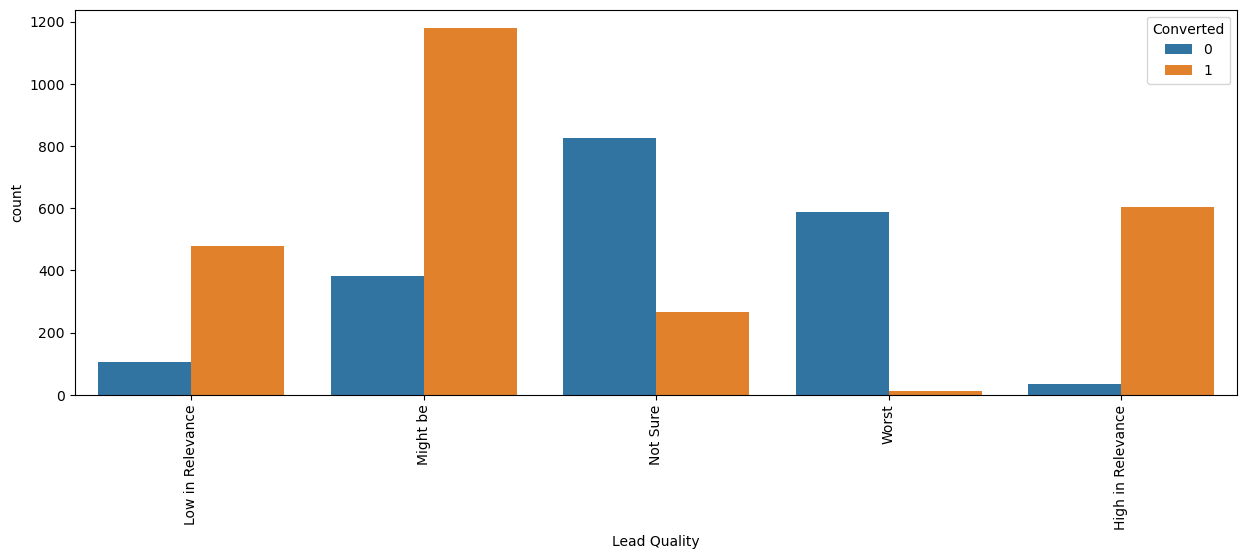

In [11]:
# Lead Quality seems to be an important column - plot to verify intuition

plt.figure(figsize=(15,5))
s1=sns.countplot(leads['Lead Quality'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

# the analysts' intuition seems to be right, keeping this column

In [12]:
#drop columns with more than 45% missing values - except Lead Quality

# for i in leads.columns:
#     if((100*(leads[i].isnull().sum()/leads.shape[0])) >= 45):
#         leads.drop(i, 1, inplace = True)

leads = leads.drop(['How did you hear about X Education','Lead Profile','Asymmetrique Activity Index','Asymmetrique Profile Index',
                  'Asymmetrique Activity Score','Asymmetrique Profile Score'], axis = 1 )

In [13]:
#check for null values in each column

# round(100*(leads.isnull().sum()/leads.shape[0]), 2)

In [14]:
# derive insights from the values in the columns

for i in leads.columns:
    print(leads[i].value_counts())
    print('************************************')
    

# INSIGHTS: the below columns have unique values and dont contribute to the analysis and hence can be dropped
# Prospect ID
# Lead Number
# Magazine
# Receive More Updates About Our Courses
# Update me on Supply Chain Content
# Get updates on DM Content
# I agree to pay the amount through cheque
# A free copy of Mastering The Interview


7927b2df-8bba-4d29-b9a2-b6e0beafe620    1
22e9d4ef-d294-4ebf-81c7-7c7a1105aeea    1
46befc49-253a-419b-abea-2fd978d2e2b1    1
9d35a2c2-09d8-439f-9875-0e8bbf267f5a    1
f0de9371-4dc2-48c2-9785-a08d6fc4fcb5    1
                                       ..
ff1f7582-cb7b-4b94-9cdc-3d0d0afdd9a3    1
644099a2-3da4-4d23-9546-7676340a372b    1
2a093175-415b-4321-9e69-ed8d9df65a3c    1
c66249a3-8500-4c66-a511-312d914573de    1
571b5c8e-a5b2-4d57-8574-f2ffb06fdeff    1
Name: Prospect ID, Length: 9240, dtype: int64
************************************
660737    1
603303    1
602561    1
602557    1
602540    1
         ..
630422    1
630405    1
630403    1
630390    1
579533    1
Name: Lead Number, Length: 9240, dtype: int64
************************************
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64
************************************
Google     

In [15]:
# Drop abv columns

leads = leads.drop(['Prospect ID', 'Lead Number', 'Magazine', 'Receive More Updates About Our Courses',
              'Update me on Supply Chain Content', 'Get updates on DM Content',
              'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview',], axis = 1 )

In [16]:
# check the dimensions of the dataframe
leads.shape

(9240, 23)

In [17]:
# see the type of each column
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9204 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        6779 

In [18]:
#check for percentage null values in each column

round(100*(leads.isnull().sum()/leads.shape[0]), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Advertisement                             0.00
Through Re

##### Impute missing values

In [19]:
# Lead Source - less than 1% null values - we can delete these rows from the dataframe
print(leads['Lead Source'].isnull().sum())
leads['Lead Source'].value_counts()
leads = leads[~pd.isnull(leads['Lead Source'])]

36


In [20]:
# TotalVisits - this column has outliers - impute with median

leads['TotalVisits'].replace(np.NaN, leads['TotalVisits'].median(), inplace =True)

In [21]:
# Page Views Per Visit - this column has outliers - impute with median

leads['Page Views Per Visit'].replace(np.NaN, leads['Page Views Per Visit'].median(), inplace =True)

In [22]:
# Last Activity - replace null values with 'Missing'

print(leads['Last Activity'].isnull().sum())
leads['Last Activity'].value_counts()

leads['Last Activity'] = leads['Last Activity'].replace(np.NaN,'Missing')

101


In [23]:
# Country - replace the null values with mode - India

print(leads['Country'].isnull().sum())
print(leads['Country'].value_counts())

leads['Country'] = leads['Country'].replace(np.NaN,'India') 

2426
India                   6491
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malaysia 

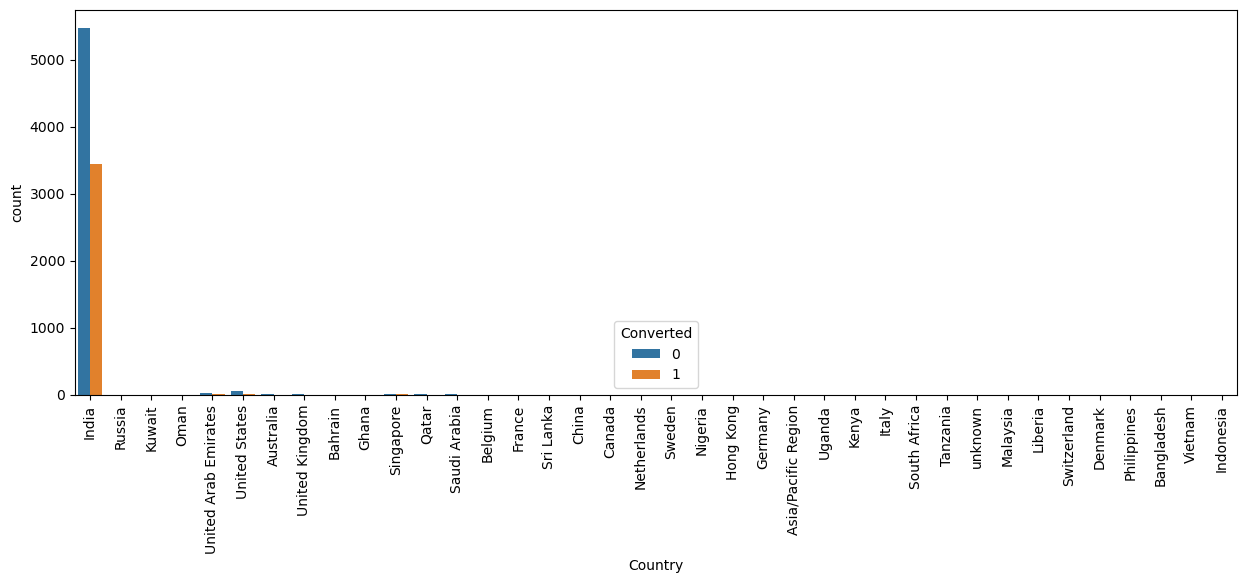

In [24]:
#plotting spread of Country columnn 
plt.figure(figsize=(15,5))
s1=sns.countplot(leads.Country, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

# this column has mostly a unique value and is not signficant for analysis - hence dropping
leads = leads.drop(['Country'], axis = 1 )

In [25]:
# Specialization - replace null values with 'Missing'

print(leads['Specialization'].isnull().sum())
print(leads['Specialization'].value_counts())

leads['Specialization'] = leads['Specialization'].replace(np.NaN, 'Missing')

1438
Missing                              1914
Finance Management                    973
Human Resource Management             847
Marketing Management                  837
Operations Management                 502
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 158
Hospitality Management                114
E-COMMERCE                            111
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64


In [26]:
# What is your current occupation - replace null value with 'Missing'

print(leads['What is your current occupation'].isnull().sum())
print(leads['What is your current occupation'].value_counts())

leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.NaN, 'Missing')

2690
Unemployed              5567
Working Professional     704
Student                  209
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64


In [27]:
# What matters most to you in choosing a course - replace null value with 'Missing'

print(leads['What matters most to you in choosing a course'].isnull().sum())
print(leads['What matters most to you in choosing a course'].value_counts())

leads['What matters most to you in choosing a course'] = leads['What matters most to you in choosing a course'].replace(np.NaN, 'Missing')

# this column has mostly a unique value and is not signficant for analysis - hence dropping
leads = leads.drop(['What matters most to you in choosing a course'], axis = 1 )

2709
Better Career Prospects      6492
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64


In [28]:
# Tags - replace null value with 'Missing'      

print(leads['Tags'].isnull().sum())
print(leads['Tags'].value_counts())

leads['Tags'] = leads['Tags'].replace(np.NaN, 'Missing')

3342
Will revert after reading the email                  2052
Ringing                                              1200
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          174
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    26
in touch with EINS                                     12
Lost to O

In [29]:
# Lead Quality 

print(leads['Lead Quality'].isnull().sum())
print(leads['Lead Quality'].value_counts())

leads['Lead Quality'] = leads['Lead Quality'].replace(np.NaN, 'Missing')

4753
Might be             1545
Not Sure             1090
High in Relevance     632
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64


In [30]:
# City - replace null values with 'missing'

print(leads['City'].isnull().sum())
print(leads['City'].value_counts())

leads['City'] = leads['City'].replace(np.NaN, 'Missing')

1420
Mumbai                         3220
Missing                        2218
Thane & Outskirts               751
Other Cities                    686
Other Cities of Maharashtra     456
Other Metro Cities              379
Tier II Cities                   74
Name: City, dtype: int64


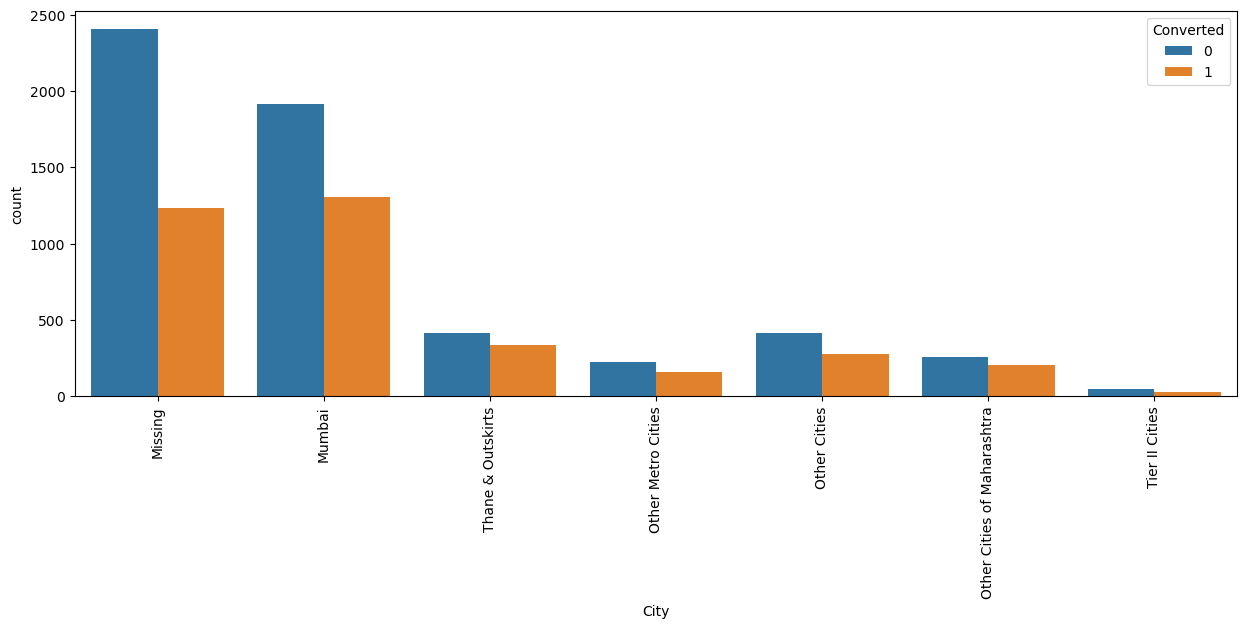

In [31]:
#plotting spread of City columnn - can provide valuable insights
plt.figure(figsize=(15,5))
s1=sns.countplot(leads.City, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [32]:
# check for percentage null values in each column

round(100*(leads.isnull().sum()/leads.shape[0]), 2)

Lead Origin                        0.0
Lead Source                        0.0
Do Not Email                       0.0
Do Not Call                        0.0
Converted                          0.0
TotalVisits                        0.0
Total Time Spent on Website        0.0
Page Views Per Visit               0.0
Last Activity                      0.0
Specialization                     0.0
What is your current occupation    0.0
Search                             0.0
Newspaper Article                  0.0
X Education Forums                 0.0
Newspaper                          0.0
Digital Advertisement              0.0
Through Recommendations            0.0
Tags                               0.0
Lead Quality                       0.0
City                               0.0
Last Notable Activity              0.0
dtype: float64

In [33]:
# check the dimensions of the dataframe
leads.shape

(9204, 21)

##### Transforming Data

In [34]:
# Convert binary variables to 0/1

convertCols =  ['Do Not Email', 'Do Not Call', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 
            'Digital Advertisement','Through Recommendations']

def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

leads[convertCols] = leads[convertCols].apply(binary_map)
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,...,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,Lead Quality,City,Last Notable Activity
0,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,Missing,...,0,0,0,0,0,0,Interested in other courses,Low in Relevance,Missing,Modified
1,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,Missing,...,0,0,0,0,0,0,Ringing,Missing,Missing,Email Opened
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,Business Administration,...,0,0,0,0,0,0,Will revert after reading the email,Might be,Mumbai,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,Media and Advertising,...,0,0,0,0,0,0,Ringing,Not Sure,Mumbai,Modified
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,Missing,...,0,0,0,0,0,0,Will revert after reading the email,Might be,Mumbai,Modified


In [35]:
# the following columns seems to have irrelevant data like Ringing, Unreachable, Modified - drop them

leads = leads.drop(['Tags','Last Activity','Last Notable Activity'], axis = 1 )
leads.shape

(9204, 18)

In [36]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9204 entries, 0 to 9239
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Lead Origin                      9204 non-null   object 
 1   Lead Source                      9204 non-null   object 
 2   Do Not Email                     9204 non-null   int64  
 3   Do Not Call                      9204 non-null   int64  
 4   Converted                        9204 non-null   int64  
 5   TotalVisits                      9204 non-null   float64
 6   Total Time Spent on Website      9204 non-null   int64  
 7   Page Views Per Visit             9204 non-null   float64
 8   Specialization                   9204 non-null   object 
 9   What is your current occupation  9204 non-null   object 
 10  Search                           9204 non-null   int64  
 11  Newspaper Article                9204 non-null   int64  
 12  X Education Forums  

In [37]:
#Create dummy variables

dummyCols = ['Lead Origin', 'Lead Source','Specialization','What is your current occupation','Lead Quality','City']

dummy = pd.get_dummies(leads[dummyCols], drop_first=True)
leads = pd.concat([leads,dummy],axis=1)
leads = leads.drop(dummyCols, axis=1)
leads.head()

,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,...,Lead Quality_Might be,Lead Quality_Missing,Lead Quality_Not Sure,Lead Quality_Worst,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
0,0,0,0,0.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,5.0,674,2.5,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,2.0,1532,2.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,0,0,0,1.0,305,1.0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,1,2.0,1428,1.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [38]:
# checking type of all columns and its statistical data

leads.info()
leads.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9204 entries, 0 to 9239
Data columns (total 70 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Do Not Email                                          9204 non-null   int64  
 1   Do Not Call                                           9204 non-null   int64  
 2   Converted                                             9204 non-null   int64  
 3   TotalVisits                                           9204 non-null   float64
 4   Total Time Spent on Website                           9204 non-null   int64  
 5   Page Views Per Visit                                  9204 non-null   float64
 6   Search                                                9204 non-null   int64  
 7   Newspaper Article                                     9204 non-null   int64  
 8   X Education Forums                                    9204

,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,...,Lead Quality_Might be,Lead Quality_Missing,Lead Quality_Not Sure,Lead Quality_Worst,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
count,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,...,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.000000,9204.00000
mean,0.078336,0.000217,0.383746,3.449587,489.005541,2.364923,0.001521,0.000217,0.000109,0.000109,...,0.167862,0.516406,0.118427,0.065298,0.349848,0.074533,0.049544,0.041178,0.081595,0.00804
std,0.268713,0.014740,0.486324,4.824662,547.980340,2.145999,0.038973,0.014740,0.010423,0.010423,...,0.373764,0.499758,0.323130,0.247064,0.476948,0.262650,0.217012,0.198712,0.273762,0.08931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,1.000000,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,3.000000,250.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,1.000000,5.000000,938.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,251.000000,2272.000000,55.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [39]:
# Check the Lead Conversion Rate
converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
converted

38.374619730551935

##### Test-Train Split

In [40]:
X=leads.drop('Converted',1)
y=leads['Converted'] 

# Splitting the datset into train and test dataset

X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [41]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,...,Lead Quality_Might be,Lead Quality_Missing,Lead Quality_Not Sure,Lead Quality_Worst,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
5310,0,0,0.119242,-0.721902,0.728793,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2181,0,0,1.050903,-0.429014,2.541043,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8215,0,0,-0.812419,-0.905639,-1.083457,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8887,0,0,-0.346589,-0.487228,-0.177332,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7920,0,0,0.119242,-0.547261,0.728793,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


##### Model Building

In [42]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6442
Model:                            GLM   Df Residuals:                     6373
Model Family:                Binomial   Df Model:                           68
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 19 Jun 2023   Deviance:                   1.6173e+05
Time:                        21:58:14   Pearson chi2:                 7.91e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                 5.637e+15   6.88e+07   8.19e+07      0.000    5.64e+15    5.64e+15
Do Not Email                                         -5.111e+14    3.2e+06   -1.6e+08      0.000   -5.11e+14   -5.11e+14
Do Not Call                                           9.526e+14   6.73e+07   1.42e+07      0.000    9.53e+14    9.53e+14
TotalVisits                                           7.224e+12   1.07e+06   6.77e+06      0.000    7.22e+12    7.22e+12
Total Time Spent on Website                           -1.92e+14   9.72e+05  -1.98e+08      0.000   -1.92e+14   -1.92e+14
Page Views Per Visit                                 -6.472e+12   1.22e+06  -5.31e+06      0.000   -6.47e+12   -6.47e+12
Search                                                5.727e+13   2.16e+07   2.65e+06      0.000    5.73e+13    5.73e+13
Newspaper Article                                     3.233e+15   6.73e+07    4.8e+07      0.000    3.23e+15    3.23e+15
X Education Forums                                   -6.519e+15   1.12e+08  -5.79e+07      0.000   -6.52e+15   -6.52e+15
Newspaper                                            -3.621e+15   6.74e+07  -5.37e+07      0.000   -3.62e+15   -3.62e+15
Digital Advertisement                                -3.656e+14   4.77e+07  -7.67e+06      0.000   -3.66e+14   -3.66e+14
Through Recommendations                              -2.011e+14   3.05e+07   -6.6e+06      0.000   -2.01e+14   -2.01e+14
Lead Origin_Landing Page Submission                   3.323e+14   3.68e+06   9.03e+07      0.000    3.32e+14    3.32e+14
Lead Origin_Lead Add Form                            -7.917e+14   4.77e+07  -1.66e+07      0.000   -7.92e+14   -7.92e+14
Lead Origin_Lead Import                               5.742e+15   6.86e+07   8.38e+07      0.000    5.74e+15    5.74e+15
Lead Source_Direct Traffic                           -5.089e+15   6.15e+07  -8.28e+07      0.000   -5.09e+15   -5.09e+15
Lead Source_Facebook                                 -1.107e+16   9.13e+07  -1.21e+08      0.000   -1.11e+16   -1.11e+16
Lead Source_Google                                   -4.861e+15   6.14e+07  -7.91e+07      0.000   -4.86e+15   -4.86e+15
Lead Source_Live Chat                                -2.119e+14   6.14e+07  -3.45e+06      0.000   -2.12e+14   -2.12e+14
Lead Source_NC_EDM                                    5.449e+14    9.1e+07   5.99e+06      0.000    5.45e+14    5.45e+14
Lead Source_Olark Chat                               -4.139e+15   6.15e+07  -6.73e+07      0.000   -4.14e+15   -4.14e+15
Lead Source_Organic Search                           -5.073e+15   6.15e+07  -8.25e+07      0.000   -5.07e+15   -5.07e+15
Lead Source_Pay per Click Ads                        -9.27

In [43]:
# Feature Selection using RFE

logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select = 15)
rfe = rfe.fit(X_train, y_train)

In [44]:
rfe.support_

array([ True, False, False,  True, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False])

In [45]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 22),
 ('TotalVisits', False, 41),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 40),
 ('Search', False, 10),
 ('Newspaper Article', False, 44),
 ('X Education Forums', False, 32),
 ('Newspaper', True, 1),
 ('Digital Advertisement', False, 30),
 ('Through Recommendations', False, 31),
 ('Lead Origin_Landing Page Submission', False, 18),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 20),
 ('Lead Source_Direct Traffic', False, 14),
 ('Lead Source_Facebook', False, 5),
 ('Lead Source_Google', False, 16),
 ('Lead Source_Live Chat', False, 7),
 ('Lead Source_NC_EDM', True, 1),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 15),
 ('Lead Source_Pay per Click Ads', False, 29),
 ('Lead Source_Press_Release', False, 28),
 ('Lead Source_Reference', False, 17),
 ('Lead Source_Referral Sites', False, 11),
 ('Lead Source_Social Media', False, 54),
 ('Lead Sour

In [46]:
col = X_train.columns[rfe.support_]
col

Index(['Do Not Email', 'Total Time Spent on Website', 'Newspaper',
       'Lead Origin_Lead Add Form', 'Lead Source_NC_EDM',
       'Lead Source_Olark Chat', 'Lead Source_Welingak Website',
       'What is your current occupation_Housewife',
       'What is your current occupation_Missing',
       'What is your current occupation_Working Professional',
       'Lead Quality_Low in Relevance', 'Lead Quality_Might be',
       'Lead Quality_Missing', 'Lead Quality_Not Sure', 'Lead Quality_Worst'],
      dtype='object')

In [47]:
X_train.columns[~rfe.support_]

Index(['Do Not Call', 'TotalVisits', 'Page Views Per Visit', 'Search',
       'Newspaper Article', 'X Education Forums', 'Digital Advertisement',
       'Through Recommendations', 'Lead Origin_Landing Page Submission',
       'Lead Origin_Lead Import', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google', 'Lead Source_Live Chat',
       'Lead Source_Organic Search', 'Lead Source_Pay per Click Ads',
       'Lead Source_Press_Release', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_bing', 'Lead Source_blog',
       'Lead Source_google', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
      

In [48]:
# model 2

X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6442
Model:                            GLM   Df Residuals:                     6426
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2396.1
Date:                Mon, 19 Jun 2023   Deviance:                       4792.2
Time:                        21:58:17   Pearson chi2:                 6.79e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.4499
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.2116      0.229      9.649      0.000       1.762       2.661
Do Not Email                                            -1.1887      0.179     -6.645      0.000      -1.539      -0.838
Total Time Spent on Website                              1.1084      0.043     25.652      0.000       1.024       1.193
Newspaper                                              -23.7637   4.82e+04     -0.000      1.000   -9.45e+04    9.44e+04
Lead Origin_Lead Add Form                                2.4330      0.227     10.720      0.000       1.988       2.878
Lead Source_NC_EDM                                      23.8321   4.82e+04      0.000      1.000   -9.44e+04    9.45e+04
Lead Source_Olark Chat                                   1.2725      0.107     11.854      0.000       1.062       1.483
Lead Source_Welingak Website                             4.4294      1.034      4.284      0.000       2.403       6.456
What is your current occupation_Housewife               21.3345   1.77e+04      0.001      0.999   -3.46e+04    3.47e+04
What is your current occupation_Missing                 -0.8404      0.100     -8.437      0.000      -1.036      -0.645
What is your current occupation_Working Professional     1.6499      0.195      8.470      0.000       1.268       2.032
Lead Quality_Low in Relevance                           -1.5209      0.268     -5.676      0.000      -2.046      -0.996
Lead Quality_Might be                                   -1.7565      0.243     -7.225      0.000      -2.233      -1.280
Lead Quality_Missing                                    -3.5106      0.239    -14.692      0.000      -3.979      -3.042
Lead Quality_Not Sure                                   -3.6637      0.248    -14.748      0.000      -4.151      -3.177
Lead Quality_Worst                                      -6.0758      0.382    -15.924      0.000      -6.824      -5.328
========================================================================================================================
"""

In [49]:
#check VIF score

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,Lead Quality_Missing,2.68
8,What is your current occupation_Missing,2.40
5,Lead Source_Olark Chat,1.53
3,Lead Origin_Lead Add Form,1.49
9,What is your current occupation_Working Profes...,1.36
6,Lead Source_Welingak Website,1.34
11,Lead Quality_Might be,1.30
1,Total Time Spent on Website,1.26
10,Lead Quality_Low in Relevance,1.13
0,Do Not Email,1.12


In [50]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

5310    0.109174
2181    0.850184
8215    0.133450
8887    0.064193
7920    0.060309
4947    0.938333
3073    0.843841
2722    0.933122
499     0.026714
8330    0.992122
dtype: float64

In [51]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.10917432, 0.85018372, 0.13344983, 0.0641925 , 0.06030942,
       0.93833349, 0.84384111, 0.93312177, 0.02671351, 0.99212152])

In [52]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.109174,5310
1,0,0.850184,2181
2,0,0.133450,8215
3,0,0.064193,8887
4,0,0.060309,7920


In [53]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.109174,5310,0
1,0,0.850184,2181,1
2,0,0.133450,8215,0
3,0,0.064193,8887,0
4,0,0.060309,7920,0


In [54]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3507  393]
 [ 685 1857]]


In [55]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.832660664389941


#### drop features until all the features attain significant p-value<0.05 and vif-values < 4.

In [56]:
col = col.drop('What is your current occupation_Housewife',1)

In [57]:
X_train[col]

,Do Not Email,Total Time Spent on Website,Newspaper,Lead Origin_Lead Add Form,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Welingak Website,What is your current occupation_Missing,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Missing,Lead Quality_Not Sure,Lead Quality_Worst
5310,0,-0.721902,0,0,0,0,0,0,0,0,0,1,0,0
2181,0,-0.429014,0,0,0,0,0,0,0,0,0,0,0,0
8215,0,-0.905639,0,0,0,1,0,1,0,0,0,1,0,0
8887,0,-0.487228,0,0,0,0,0,1,0,0,0,1,0,0
7920,0,-0.547261,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0,-0.905639,0,1,0,0,0,0,0,0,0,0,0,0
79,0,0.376883,0,1,0,0,0,0,1,1,0,0,0,0
8070,0,-0.905639,0,1,0,0,0,0,1,0,1,0,0,0
6963,0,1.020873,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
X_train_sm=sm.add_constant(X_train[col])                            
logm3=sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm3.fit()    
res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6442
Model:                            GLM   Df Residuals:                     6427
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2397.7
Date:                Mon, 19 Jun 2023   Deviance:                       4795.4
Time:                        21:58:17   Pearson chi2:                 6.80e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.4496
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.2116      0.229      9.650      0.000       1.762       2.661
Do Not Email                                            -1.1907      0.179     -6.653      0.000      -1.541      -0.840
Total Time Spent on Website                              1.1077      0.043     25.647      0.000       1.023       1.192
Newspaper                                              -21.7627   1.77e+04     -0.001      0.999   -3.48e+04    3.47e+04
Lead Origin_Lead Add Form                                2.4349      0.227     10.736      0.000       1.990       2.879
Lead Source_NC_EDM                                      21.8317   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
Lead Source_Olark Chat                                   1.2703      0.107     11.835      0.000       1.060       1.481
Lead Source_Welingak Website                             4.4267      1.034      4.281      0.000       2.400       6.453
What is your current occupation_Missing                 -0.8402      0.100     -8.435      0.000      -1.035      -0.645
What is your current occupation_Working Professional     1.6450      0.195      8.442      0.000       1.263       2.027
Lead Quality_Low in Relevance                           -1.5010      0.268     -5.606      0.000      -2.026      -0.976
Lead Quality_Might be                                   -1.7539      0.243     -7.215      0.000      -2.230      -1.277
Lead Quality_Missing                                    -3.5099      0.239    -14.690      0.000      -3.978      -3.042
Lead Quality_Not Sure                                   -3.6631      0.248    -14.747      0.000      -4.150      -3.176
Lead Quality_Worst                                      -6.0746      0.382    -15.923      0.000      -6.822      -5.327
========================================================================================================================
"""

In [59]:
#check VIF score

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
11,Lead Quality_Missing,2.68
7,What is your current occupation_Missing,2.40
5,Lead Source_Olark Chat,1.53
3,Lead Origin_Lead Add Form,1.49
8,What is your current occupation_Working Profes...,1.35
6,Lead Source_Welingak Website,1.34
10,Lead Quality_Might be,1.30
1,Total Time Spent on Website,1.26
0,Do Not Email,1.12
9,Lead Quality_Low in Relevance,1.12


#### Predicting the train dataset with our final model

In [60]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

5310    0.109295
2181    0.850227
8215    0.133382
8887    0.064270
7920    0.060385
4947    0.938175
3073    0.846362
2722    0.932955
499     0.026704
8330    0.992078
dtype: float64

In [61]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.10929466, 0.85022749, 0.13338231, 0.06426965, 0.06038458,
       0.9381753 , 0.84636229, 0.93295457, 0.02670391, 0.99207809])

In [62]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.109295,5310
1,0,0.850227,2181
2,0,0.133382,8215
3,0,0.064270,8887
4,0,0.060385,7920


In [63]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.109295,5310,0
1,0,0.850227,2181,1
2,0,0.133382,8215,0
3,0,0.064270,8887,0
4,0,0.060385,7920,0


In [64]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3506  394]
 [ 685 1857]]


In [65]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.832505433095312


In [66]:
col = col.drop('Newspaper',1)

In [67]:
X_train_sm=sm.add_constant(X_train[col])                            
logm4=sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm4.fit()    
res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6442
Model:                            GLM   Df Residuals:                     6428
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2399.1
Date:                Mon, 19 Jun 2023   Deviance:                       4798.3
Time:                        21:58:17   Pearson chi2:                 6.80e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.4494
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.2116      0.229      9.652      0.000       1.763       2.661
Do Not Email                                            -1.1893      0.179     -6.647      0.000      -1.540      -0.839
Total Time Spent on Website                              1.1050      0.043     25.619      0.000       1.020       1.190
Lead Origin_Lead Add Form                                2.4326      0.227     10.727      0.000       1.988       2.877
Lead Source_NC_EDM                                      21.8326   1.77e+04      0.001      0.999   -3.47e+04    3.48e+04
Lead Source_Olark Chat                                   1.2675      0.107     11.815      0.000       1.057       1.478
Lead Source_Welingak Website                             4.4254      1.034      4.280      0.000       2.399       6.452
What is your current occupation_Missing                 -0.8398      0.100     -8.435      0.000      -1.035      -0.645
What is your current occupation_Working Professional     1.6452      0.195      8.444      0.000       1.263       2.027
Lead Quality_Low in Relevance                           -1.5006      0.268     -5.605      0.000      -2.025      -0.976
Lead Quality_Might be                                   -1.7537      0.243     -7.216      0.000      -2.230      -1.277
Lead Quality_Missing                                    -3.5091      0.239    -14.689      0.000      -3.977      -3.041
Lead Quality_Not Sure                                   -3.6690      0.248    -14.772      0.000      -4.156      -3.182
Lead Quality_Worst                                      -6.0726      0.381    -15.921      0.000      -6.820      -5.325
========================================================================================================================
"""

In [68]:
#check VIF score

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
10,Lead Quality_Missing,2.68
6,What is your current occupation_Missing,2.40
4,Lead Source_Olark Chat,1.53
2,Lead Origin_Lead Add Form,1.49
7,What is your current occupation_Working Profes...,1.35
5,Lead Source_Welingak Website,1.34
9,Lead Quality_Might be,1.30
1,Total Time Spent on Website,1.26
0,Do Not Email,1.12
8,Lead Quality_Low in Relevance,1.12


In [69]:
col = col.drop('Lead Source_NC_EDM',1)

In [70]:
X_train_sm=sm.add_constant(X_train[col])                            
logm5=sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res = logm5.fit()    
res.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6442
Model:                            GLM   Df Residuals:                     6429
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2400.7
Date:                Mon, 19 Jun 2023   Deviance:                       4801.3
Time:                        21:58:18   Pearson chi2:                 6.80e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4491
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.2119      0.229      9.653      0.000       1.763       2.661
Do Not Email                                            -1.1906      0.179     -6.655      0.000      -1.541      -0.840
Total Time Spent on Website                              1.1053      0.043     25.630      0.000       1.021       1.190
Lead Origin_Lead Add Form                                2.4326      0.227     10.727      0.000       1.988       2.877
Lead Source_Olark Chat                                   1.2655      0.107     11.801      0.000       1.055       1.476
Lead Source_Welingak Website                             4.4255      1.034      4.280      0.000       2.399       6.452
What is your current occupation_Missing                 -0.8356      0.099     -8.400      0.000      -1.031      -0.641
What is your current occupation_Working Professional     1.6452      0.195      8.444      0.000       1.263       2.027
Lead Quality_Low in Relevance                           -1.5006      0.268     -5.605      0.000      -2.025      -0.976
Lead Quality_Might be                                   -1.7537      0.243     -7.216      0.000      -2.230      -1.277
Lead Quality_Missing                                    -3.5088      0.239    -14.688      0.000      -3.977      -3.041
Lead Quality_Not Sure                                   -3.6692      0.248    -14.772      0.000      -4.156      -3.182
Lead Quality_Worst                                      -6.0726      0.381    -15.920      0.000      -6.820      -5.325
========================================================================================================================
"""

In [71]:
#check VIF score

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
9,Lead Quality_Missing,2.68
5,What is your current occupation_Missing,2.40
3,Lead Source_Olark Chat,1.53
2,Lead Origin_Lead Add Form,1.49
6,What is your current occupation_Working Profes...,1.35
4,Lead Source_Welingak Website,1.34
8,Lead Quality_Might be,1.30
1,Total Time Spent on Website,1.26
0,Do Not Email,1.12
7,Lead Quality_Low in Relevance,1.12


In [72]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

5310    0.109608
2181    0.850401
8215    0.133781
8887    0.064705
7920    0.060804
4947    0.938142
3073    0.846187
2722    0.932930
499     0.026697
8330    0.992066
dtype: float64

In [73]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.10960759, 0.85040147, 0.13378065, 0.06470502, 0.06080355,
       0.93814159, 0.84618715, 0.93292994, 0.02669743, 0.99206621])

In [74]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.109608,5310
1,0,0.850401,2181
2,0,0.133781,8215
3,0,0.064705,8887
4,0,0.060804,7920


In [75]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.109608,5310,0
1,0,0.850401,2181,1
2,0,0.133781,8215,0
3,0,0.064705,8887,0
4,0,0.060804,7920,0


In [76]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3506  394]
 [ 685 1857]]


In [77]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.832505433095312


In [78]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [79]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7305271439811172

In [80]:
# Let us calculate specificity
TN / float(TN+FP)

0.898974358974359

In [81]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.10102564102564103


In [82]:
# positive predictive value 
print (TP / float(TP+FP))

0.8249666814749


In [83]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8365545215938917


#### Plotting the ROC Curve

In [84]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [85]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

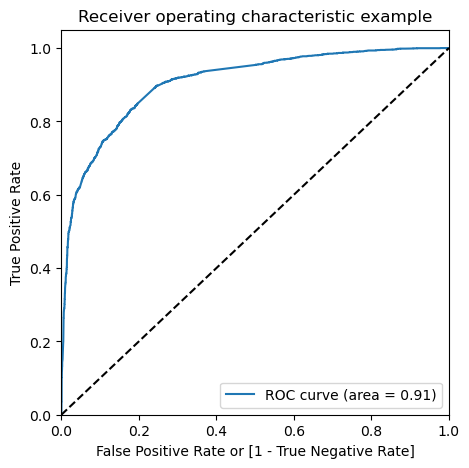

In [86]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

#### Finding Optimal Cutoff Point

In [87]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.109608,5310,0,1,1,0,0,0,0,0,0,0,0
1,0,0.850401,2181,1,1,1,1,1,1,1,1,1,1,0
2,0,0.133781,8215,0,1,1,0,0,0,0,0,0,0,0
3,0,0.064705,8887,0,1,0,0,0,0,0,0,0,0,0
4,0,0.060804,7920,0,1,0,0,0,0,0,0,0,0,0


In [88]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.394598  1.000000  0.000000
0.1   0.1  0.624495  0.973643  0.396923
0.2   0.2  0.795250  0.910307  0.720256
0.3   0.3  0.823036  0.835563  0.814872
0.4   0.4  0.827848  0.791896  0.851282
0.5   0.5  0.832505  0.730527  0.898974
0.6   0.6  0.828159  0.668371  0.932308
0.7   0.7  0.821639  0.612116  0.958205
0.8   0.8  0.802391  0.540519  0.973077
0.9   0.9  0.753958  0.397325  0.986410


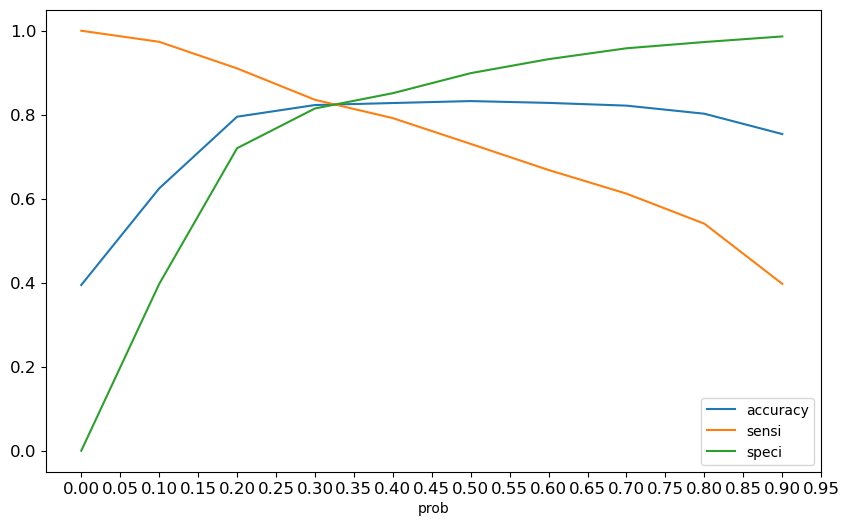

In [89]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.show()

#### From the curve above, 0.33 is the optimum point to take it as a cutoff probability.

In [90]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.109608,5310,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.850401,2181,1,1,1,1,1,1,1,1,1,1,0,1
2,0,0.133781,8215,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.064705,8887,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.060804,7920,0,1,0,0,0,0,0,0,0,0,0,0


In [91]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8230363241229431

In [92]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion2

array([[3178,  722],
       [ 418, 2124]], dtype=int64)

In [93]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [94]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8355625491738788

In [95]:
# Let us calculate specificity
TN / float(TN+FP)

0.8148717948717948

In [96]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.18512820512820513


In [97]:
# Positive predictive value 
print (TP / float(TP+FP))

0.7463106113843991


In [98]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8837597330367074


#### Precision and Recall

In [99]:

precision = confusion2[1,1]/(confusion2[0,1]+confusion2[1,1])
precision

0.7463106113843991

In [100]:
recall = confusion2[1,1]/(confusion2[1,0]+confusion2[1,1])
recall

0.8355625491738788

### Precision and recall tradeoff

In [101]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

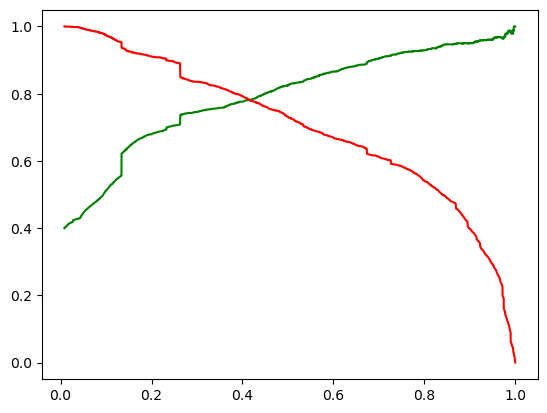

In [102]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Making predictions on the test set

In [103]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_test.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,...,Lead Quality_Might be,Lead Quality_Missing,Lead Quality_Not Sure,Lead Quality_Worst,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities
2400,0,0,0.119242,0.846232,0.728793,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
849,0,0,1.982564,-0.781935,0.275730,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
7459,0,0,-0.346589,-0.663688,-0.177332,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
6184,1,0,-0.113674,0.060346,0.275730,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4869,0,0,-0.346589,1.497498,-0.177332,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [104]:
X_test = X_test[col]
X_test.head()

,Do Not Email,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Olark Chat,Lead Source_Welingak Website,What is your current occupation_Missing,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Missing,Lead Quality_Not Sure,Lead Quality_Worst
2400,0,0.846232,0,0,0,0,0,0,1,0,0,0
849,0,-0.781935,0,0,0,1,0,0,0,1,0,0
7459,0,-0.663688,0,0,0,0,0,0,0,1,0,0
6184,1,0.060346,0,0,0,0,0,0,0,0,1,0
4869,0,1.497498,0,0,0,0,1,1,0,0,0,0


In [105]:
X_test_sm = sm.add_constant(X_test)

In [106]:
y_test_pred = res.predict(X_test_sm)


In [107]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [108]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [109]:
y_test_df['LeadID'] = y_test_df.index

In [110]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [111]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [112]:
y_pred_final.head()

,Converted,LeadID,0
0,1,2400,0.801158
1,0,849,0.047573
2,0,7459,0.116047
3,1,6184,0.070363
4,1,4869,0.982220


In [113]:

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Conversion_Prob'})

In [114]:

# Rearranging the columns
y_pred_final = y_pred_final.reindex(['LeadID','Converted','Conversion_Prob'], axis=1)

In [115]:
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.42 else 0)

In [116]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)


0.8218682114409848

In [117]:
confusion3 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
print(confusion3)

[[1506  266]
 [ 226  764]]


In [118]:
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives

In [119]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7717171717171717

In [120]:
# Let us calculate specificity
TN / float(TN+FP)

0.8498871331828443

In [121]:
Precision = confusion3[1,1]/(confusion3[0,1]+confusion3[1,1])
Precision

0.7417475728155339

In [122]:
Recall = confusion3[1,1]/(confusion3[1,0]+confusion3[1,1])
Recall

0.7717171717171717

In [123]:
#### Plotting the ROC Curve for Test Dataset

In [124]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [125]:

fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.Converted, y_pred_final.Conversion_Prob, drop_intermediate = False )

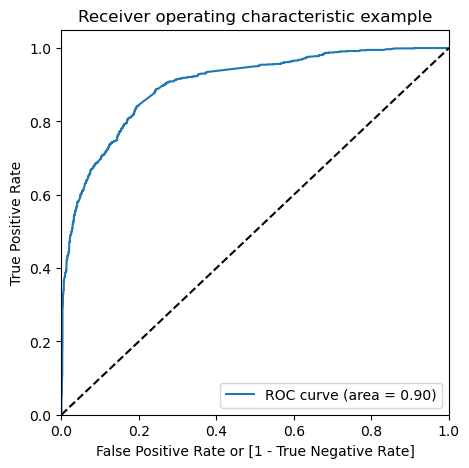

(array([0.        , 0.        , 0.        , ..., 0.99887133, 0.99943567,
        1.        ]),
 array([0.       , 0.0010101, 0.0020202, ..., 1.       , 1.       ,
        1.       ]),
 array([1.99984815, 0.99984815, 0.99972493, ..., 0.00282821, 0.00262597,
        0.00248755]))

In [126]:
draw_roc(y_pred_final.Converted, y_pred_final.Conversion_Prob)

In [127]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [128]:
auc = auc_val(fpr,tpr)
auc

0.9009710536516399

### Our model seems to be doing well with auc = 0.90

In [129]:
# Calculate Pred score foreach of the leads:

In [130]:
final_Lead_Pred = y_pred_final.append(y_train_pred_final[['LeadID','Converted','Conversion_Prob','final_predicted']])
final_Lead_Pred

,LeadID,Converted,Conversion_Prob,final_predicted
0,2400,1,0.801158,1
1,849,0,0.047573,0
2,7459,0,0.116047,0
3,6184,1,0.070363,0
4,4869,1,0.982220,1
...,...,...,...,...
6437,350,1,0.974507,1
6438,79,1,0.994545,1
6439,8070,1,0.971668,1
6440,6963,0,0.457975,1


In [131]:
final_Lead_Pred['Lead_Score'] = final_Lead_Pred['Conversion_Prob'].apply(lambda x : round(x*100))
final_Lead_Pred.head()

,LeadID,Converted,Conversion_Prob,final_predicted,Lead_Score
0,2400,1,0.801158,1,80
1,849,0,0.047573,0,5
2,7459,0,0.116047,0,12
3,6184,1,0.070363,0,7
4,4869,1,0.982220,1,98


In [132]:
final_Lead_Pred = final_Lead_Pred.set_index('LeadID').sort_index(axis = 0, ascending = True)
final_Lead_Pred.head()

,Converted,Conversion_Prob,final_predicted,Lead_Score
LeadID,,,,
0,0,0.726300,1,73
1,0,0.280372,0,28
2,1,0.926739,1,93
3,0,0.136467,0,14
4,1,0.911212,1,91


In [133]:
# Determing Feature Impoprtance
pd.options.display.float_format = '{:.2f}'.format
important_feature = res.params[1:]
important_feature

Do Not Email                                           -1.19
Total Time Spent on Website                             1.11
Lead Origin_Lead Add Form                               2.43
Lead Source_Olark Chat                                  1.27
Lead Source_Welingak Website                            4.43
What is your current occupation_Missing                -0.84
What is your current occupation_Working Professional    1.65
Lead Quality_Low in Relevance                          -1.50
Lead Quality_Might be                                  -1.75
Lead Quality_Missing                                   -3.51
Lead Quality_Not Sure                                  -3.67
Lead Quality_Worst                                     -6.07
dtype: float64

In [134]:
pd.DataFrame(important_feature).reset_index().sort_values(by=0,ascending=False)

,index,0
4,Lead Source_Welingak Website,4.43
2,Lead Origin_Lead Add Form,2.43
6,What is your current occupation_Working Profes...,1.65
3,Lead Source_Olark Chat,1.27
1,Total Time Spent on Website,1.11
5,What is your current occupation_Missing,-0.84
0,Do Not Email,-1.19
7,Lead Quality_Low in Relevance,-1.50
8,Lead Quality_Might be,-1.75
9,Lead Quality_Missing,-3.51


In [138]:
print('F1_Score: ',f1_score(y_test_pred_final.Converted, y_test_pred_final.Predicted)*100)


NameError: name 'y_test_pred_final' is not defined